# Calculate accuracy of last part 
*  using symbol reflected emotion of last part, Culcurate if generated sentence is adequately 
* dataset used to train model  ...
   - all domain
   - over sampling all domain

* I want to know ... 
  - whether can the model learn emotional features in sentences using emotional label?
  - whetehr should we use over sampling ?

In [27]:
import re
from collections import Counter
import pickle
import sentencepiece as spm
from matplotlib import pyplot as plt


# Calcurate if diversity of sentences
* Confirm how different generated sentences are.
* dataset used to train model ... 
    - over sampling all model using feature of last part
    - over sampling all model 
* prototype = "neutral"

In [3]:
id2emo = {"0":"NONE","1":"neutral","2":"anger","3":"sad",
          "4":"happy","5":"contentment","6":"all"}
proto_emotion = "neutral"
compare_emotion = ["anger","sad","happy","contentment"]

In [4]:
import re
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def diversity_rate(file_path, use_lastpart = True):
    pro_file = open("{}/{}.txt".format(file_path,proto_emotion), 'r')
    uttrs1 = pro_file.readlines()
    num_uttr = len(uttrs1)
    com_file_list = [open("{}/{}.txt".format(file_path,e), 'r')
                     for e in compare_emotion]
    uttrs2_list = [uttrs.readlines() for uttrs in com_file_list]
    acc = 0
    using_last_part = 0
    how_diff = []
    num_diff = [0] * len(compare_emotion)
    for i1, uttr1 in enumerate(uttrs1,0):
        uttr1 = uttr1.strip()
        if use_lastpart:
            if re.match("[)）]",uttr1[-1]):
                for j in range(2,len(uttr1)):
                    if re.match("[(（)]",uttr1[-j]):
                        using_last_part += 1
                        uttr1 = uttr1[:-j]
                        break
        for i2 in range(len(compare_emotion)):
            uttr2 = uttrs2_list[i2][i1].strip()
            #print("former - > ", uttr2)
            if use_lastpart:
                if re.match("[)）]",uttr2[-1]):
                    for j in range(2,len(uttr2)):
                        if re.match("[(（)]",uttr2[-j]):
                            using_last_part += 1
                            uttr2 = uttr2[:-j]
                            #print("after - > ",uttr2)
                            break
            
            if uttr1 != uttr2:
                num_diff[i2] += 1
            
        #print("number_of_lastpart : ",using_last_part)
    [how_diff.append(num_diff[i]/len(uttrs1)) for i in range(len(compare_emotion))]
    how_diff.append(sum(num_diff)/(len(uttrs1)*len(compare_emotion)))
    return num_uttr, how_diff

def print_how_diff(file_path):
    print("\nOutput file name : ", file_path)
    num_uttr, how_diff = diversity_rate(file_path)
    print("  Number of uttrances : ",num_uttr)
    print_emotion = compare_emotion + ["average"]
    print(print_emotion)
    for i, d in enumerate(how_diff):
        print("{} : {:.6f} ({} uttrances)".format(print_emotion[i], d, int(d*num_uttr)))
        x = np.array([1-d, d])
        x_label = ["same","different"]
        plt.pie(x,labels=x_label,counterclock=False, startangle=90, 
                                autopct="%.1f%%",pctdistance=0.7) 
        plt.axis('equal')
        plt.rcParams["font.size"] = 18
        plt.show()
    fig, ax = plt.subplots()
    x = print_emotion
    #np.arange(0,len(print_emotion),1)
    y = how_diff
    labels = ax.get_xticklabels()
    plt.setp(labels, rotation=25, fontsize=10)
    plt.grid()
    plt.ylim(0,1)
    plt.bar(x,y)
    print("Average of sentences is ", how_diff[-1])
    return num_uttr, how_diff

In [6]:
import sentencepiece as spm

def sentence_piece(vocab_path):
    sp = spm.SentencePieceProcessor()
    sp.Load(vocab_path)
    n_words = len(sp)
    return sp, n_words

In [7]:
from operator import add
from functools import reduce

def em_dist_1(file_path, sp):
    pro_file = open("{}/{}.txt".format(file_path,proto_emotion), 'r')
    uttrs1 = pro_file.readlines()
    uttr1_id = reduce(add, [sp.EncodeAsIds(sentence) for sentence in uttrs1])
    
    com_file_list = [open("{}/{}.txt".format(file_path,e), 'r')
                     for e in compare_emotion]   
    uttr2_list = [uttrs.readlines() for uttrs in com_file_list]
    uttr2_idlist = [reduce(add, [sp.EncodeAsIds(sentence) for sentence in uttr2]) for uttr2 in uttr2_list]
    dist1_list = []
    for uttr2_id in uttr2_idlist:
        uttr12 = set(uttr1_id + uttr2_id) 
        dist1 = len(uttr12) / len(uttr1_id + uttr2_id)
        dist1_list.append(dist1)
    print(dist1_list)
    print("average dist : ", sum(dist1_list)/len(dist1_list))
    return dist1_list

In [8]:
vocab_path1 = "../../data/twitter_dial/vocab/spvocab.model"
vocab_path2 =  "../../data/twitter_dial/vocab/spvocab_tw_label.model"

sp1, n_words1 = sentence_piece(vocab_path1)
sp2, n_words2 = sentence_piece(vocab_path2)

## over sampled all domain 

### emotion size : 6


Output file name :  ../../emotion_dialogue_model/output/emotion_6/overall/output_tw21_overall_16
  Number of uttrances :  985
['anger', 'sad', 'happy', 'contentment', 'average']
anger : 0.702538 (692 uttrances)


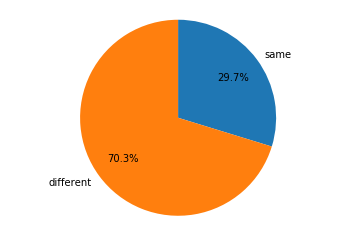

sad : 0.494416 (487 uttrances)


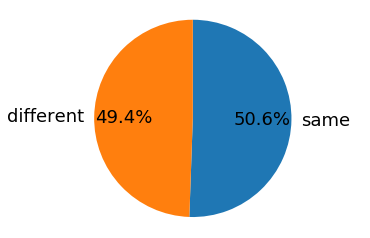

happy : 0.610152 (601 uttrances)


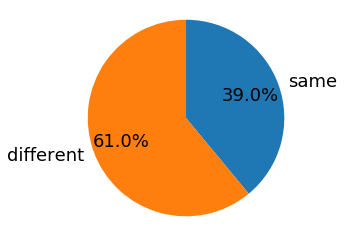

contentment : 0.478173 (471 uttrances)


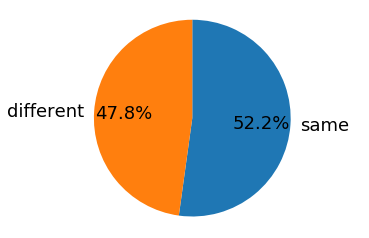

average : 0.571320 (562 uttrances)


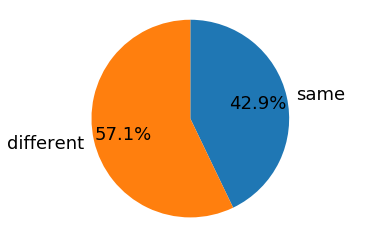

Average of sentences is  0.5713197969543147
[0.0848392939887948, 0.08404930892790437, 0.08419373793335012, 0.08435544430538172]
average dist :  0.08435944628885775


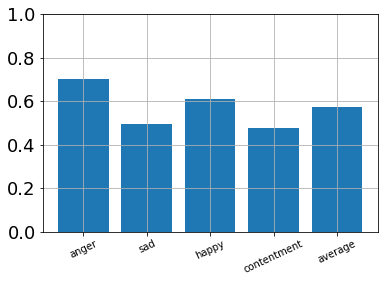

In [9]:
output_dir_size6 = "../../emotion_dialogue_model/output/emotion_6/overall/output_tw21_overall_16"
num_uttr6, how_diff6 = print_how_diff(output_dir_size6)
dist1_diff = em_dist_1(output_dir_size6,sp1)

In [10]:
refer = output_dir_size6 + "/reference_id.py"
infer = output_dir_size6 + "/allem_inf_id.py"
!mteval-corpus -e BLEU RIBES -r $refer -h $infer

mteval-corpus: error while loading shared libraries: libboost_program_options.so.1.58.0: cannot open shared object file: No such file or directory


### emotion size : 32


Output file name :  ../../emotion_dialogue_model/output/emotion_32/overall/output_32emoTw19_overall_17
  Number of uttrances :  985
['anger', 'sad', 'happy', 'contentment', 'average']
anger : 0.889340 (876 uttrances)


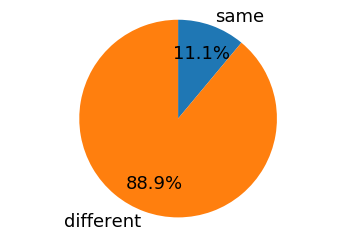

sad : 0.858883 (846 uttrances)


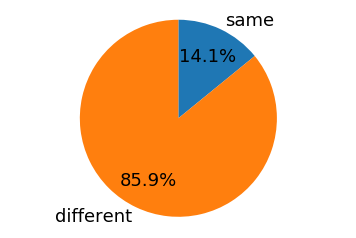

happy : 0.833503 (821 uttrances)


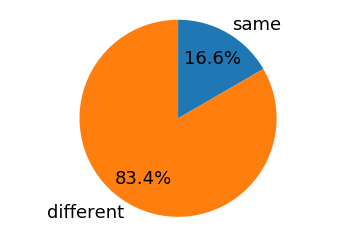

contentment : 0.725888 (715 uttrances)


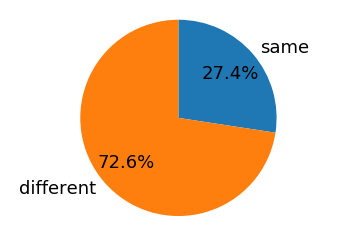

average : 0.826904 (814 uttrances)


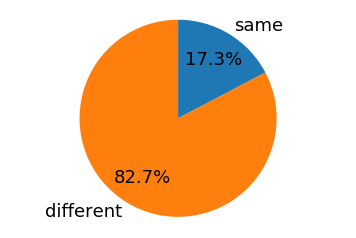

Average of sentences is  0.8269035532994924
[0.07944474943141715, 0.07240461401952085, 0.07923961585582737, 0.08578213119620065]
average dist :  0.0792177776257415


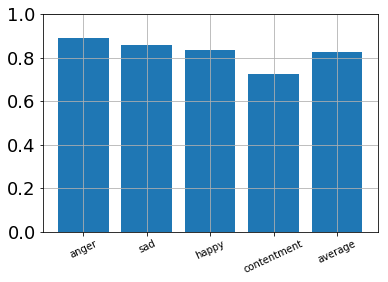

In [42]:
output_dir_size32 = "../../emotion_dialogue_model/output/emotion_32/overall/output_32emoTw19_overall_17"
print_how_diff(output_dir_size32)
dist1_diff = em_dist_1(output_dir_size32,sp2)

### emotion size : 64


Output file name :  ../../emotion_dialogue_model/output/emotion_64/overall/output_64emoTw21_overall_14
  Number of uttrances :  985
['anger', 'sad', 'happy', 'contentment', 'average']
anger : 0.887310 (874 uttrances)


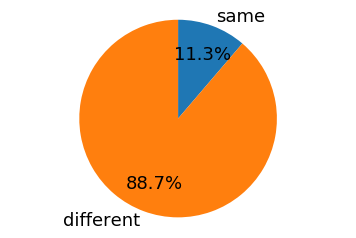

sad : 0.775635 (764 uttrances)


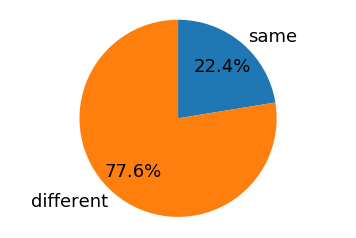

happy : 0.919797 (906 uttrances)


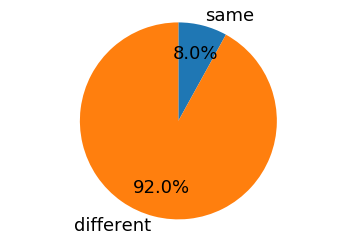

contentment : 0.784772 (773 uttrances)


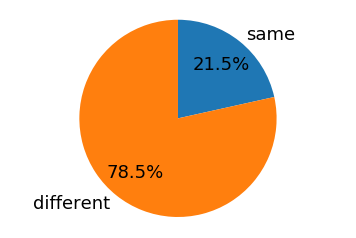

average : 0.841878 (829 uttrances)


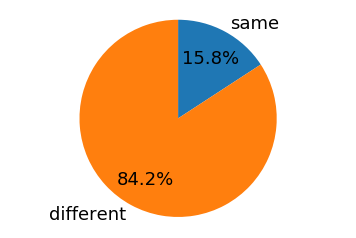

Average of sentences is  0.8418781725888325
[0.09139760253525007, 0.08537677512900337, 0.090060009926454, 0.09099590723055935]
average dist :  0.08945757370531669


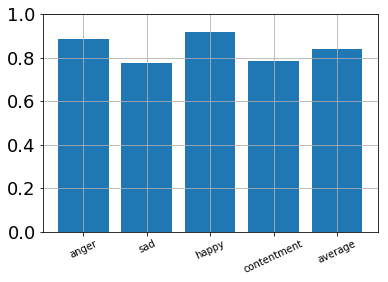

In [43]:
output_dir_size64 = "../../emotion_dialogue_model/output/emotion_64/overall/output_64emoTw21_overall_14"
print_how_diff(output_dir_size64)
dist1_diff = em_dist_1(output_dir_size64,sp2)

### emotion size : 96


Output file name :  ../../emotion_dialogue_model/output/emotion_96/overall/output_96emoTw21_overall_17
  Number of uttrances :  985
['anger', 'sad', 'happy', 'contentment', 'average']
anger : 0.847716 (835 uttrances)


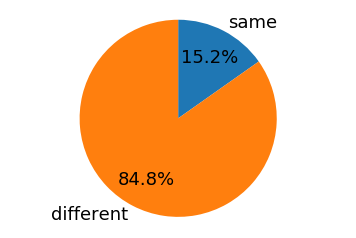

sad : 0.865990 (853 uttrances)


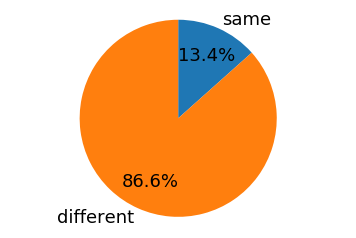

happy : 0.881218 (868 uttrances)


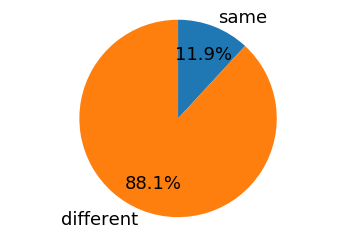

contentment : 0.712690 (702 uttrances)


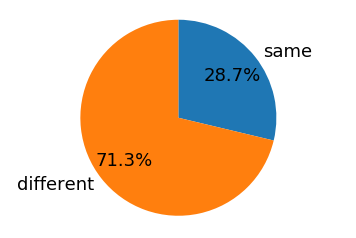

average : 0.826904 (814 uttrances)


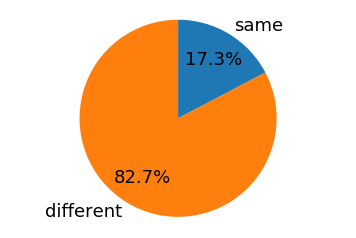

Average of sentences is  0.8269035532994924
[0.07953216374269007, 0.07738028484916452, 0.0765639589169001, 0.09788296289184388]
average dist :  0.08283984260014965


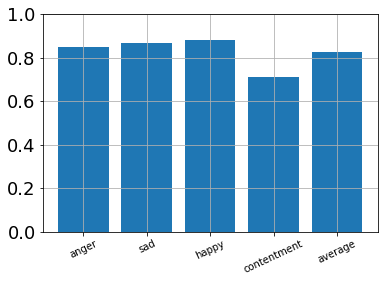

In [44]:
output_dir_size96 = "../../emotion_dialogue_model/output/emotion_96/overall/output_96emoTw21_overall_17"
print_how_diff(output_dir_size96)
dist1_diff = em_dist_1(output_dir_size96,sp2)

### emotion size : 128


Output file name :  ../../emotion_dialogue_model/output/emotion_128/overall/output_128emoTw17_overall_16
  Number of uttrances :  985
['anger', 'sad', 'happy', 'contentment', 'average']
anger : 0.889340 (876 uttrances)


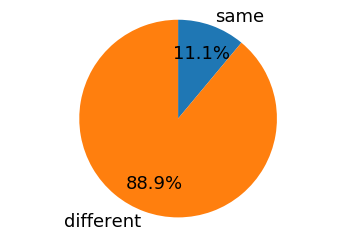

sad : 0.839594 (827 uttrances)


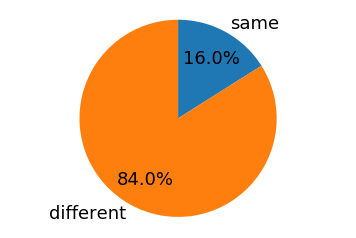

happy : 0.869036 (856 uttrances)


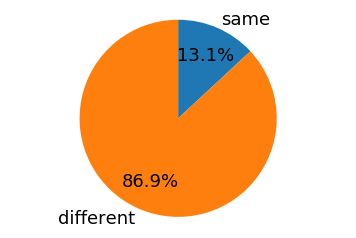

contentment : 0.832487 (820 uttrances)


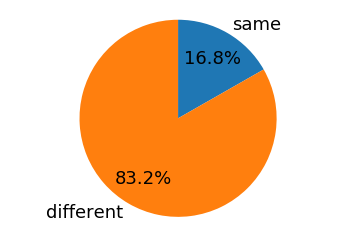

average : 0.857614 (844 uttrances)


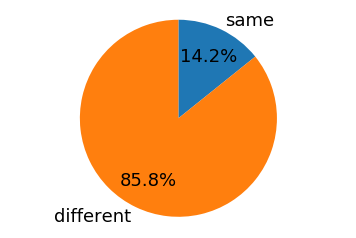

Average of sentences is  0.8576142131979695
[0.09022489024280979, 0.08070035813768404, 0.09320585654242299, 0.09232179692871877]
average dist :  0.0891132254629089


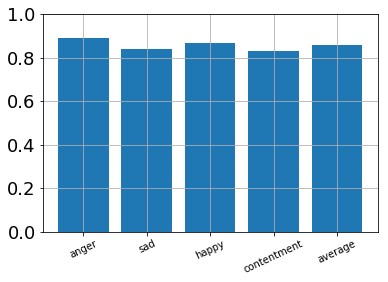

In [46]:
output_dir_size128 = "../../emotion_dialogue_model/output/emotion_128/overall/output_128emoTw17_overall_16"
print_how_diff(output_dir_size128)
dist1_diff = em_dist_1(output_dir_size128,sp2)

### over sampled cleaning only


Output file name :  ../emotion_dialogue_model/output/output_tw21_overclean_25
  Number of uttrances :  985
['NONE', 'anger', 'sad', 'happy', 'contentment', 'average']
NONE : 0.186802 (184 uttrances)


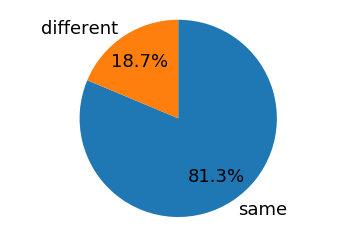

anger : 0.307614 (303 uttrances)


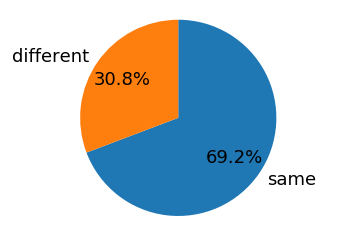

sad : 0.222335 (219 uttrances)


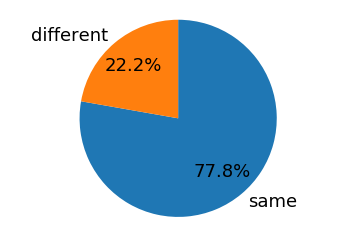

happy : 0.289340 (285 uttrances)


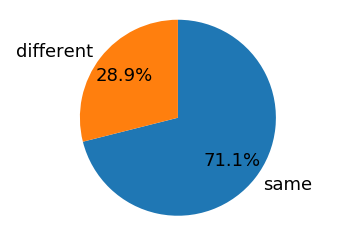

contentment : 0.237563 (234 uttrances)


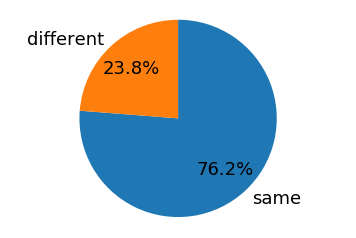

average : 0.211585 (208 uttrances)


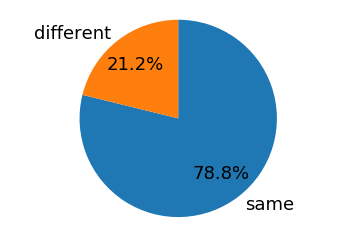

Average of sentences is  0.21158536585365853


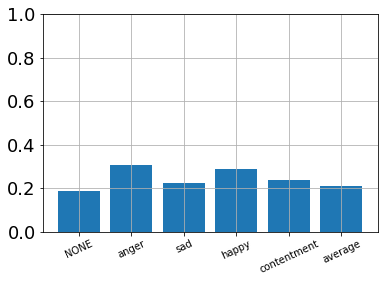

In [173]:
output_dir5 = "../emotion_dialogue_model/output/output_tw21_overclean_25"
print_how_diff(output_dir5)

### over sampled all domain and over sampled cleaning


Output file name :  ../emotion_dialogue_model/output/output_tw21_overall16_overclean_3
  Number of uttrances :  985
['NONE', 'anger', 'sad', 'happy', 'contentment', 'average']
NONE : 0.338071 (333 uttrances)


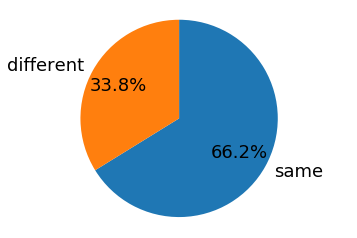

anger : 0.541117 (533 uttrances)


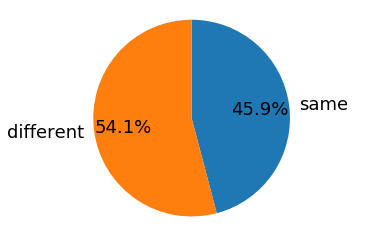

sad : 0.356345 (351 uttrances)


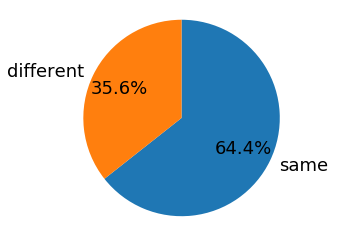

happy : 0.481218 (474 uttrances)


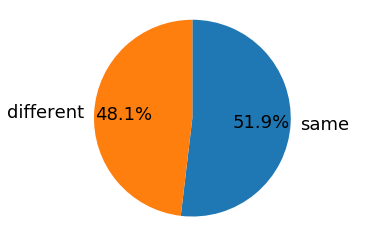

contentment : 0.353299 (348 uttrances)


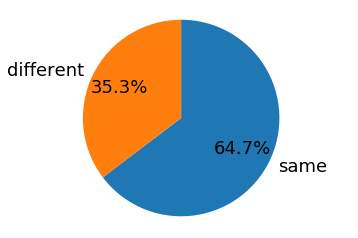

average : 0.346748 (341 uttrances)


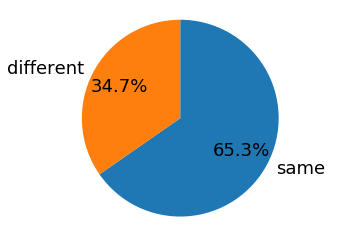

Average of sentences is  0.3467479674796748


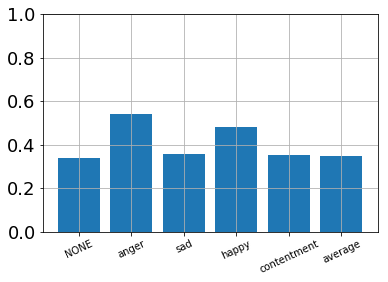

In [174]:
output_dir6 = "../emotion_dialogue_model/output/output_tw21_overall16_overclean_3"
print_how_diff(output_dir6)

### over sampled with kao all and over sampled cleaning with kao


Output file name :  ../emotion_dialogue_model/output/output_tw21_overallkao_overcleankao_3
  Number of uttrances :  985
['NONE', 'anger', 'sad', 'happy', 'contentment', 'average']
NONE : 0.506599 (499 uttrances)


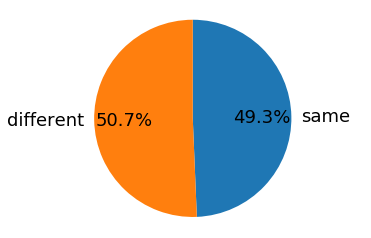

anger : 0.608122 (599 uttrances)


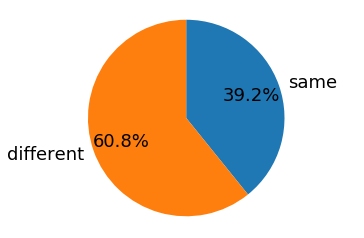

sad : 0.479188 (472 uttrances)


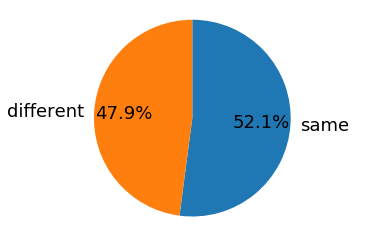

happy : 0.591878 (583 uttrances)


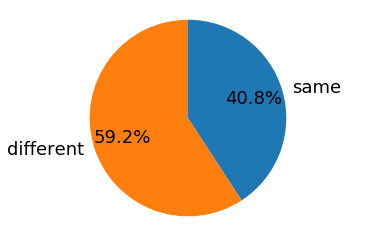

contentment : 0.505584 (498 uttrances)


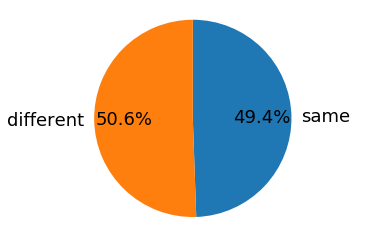

average : 0.437398 (430 uttrances)


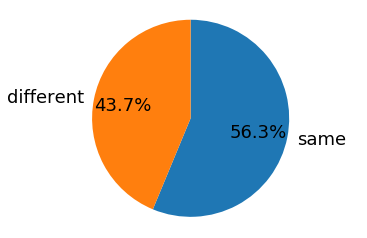

Average of sentences is  0.4373983739837398


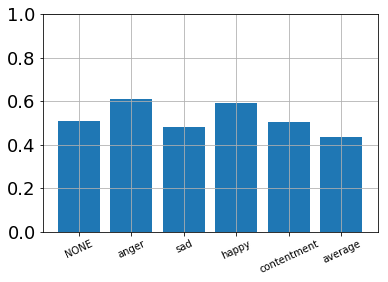

In [176]:
output_dir6 = "../emotion_dialogue_model/output/output_tw21_overallkao_overcleankao_3"
print_how_diff(output_dir6)

In [9]:
pro_file = open("{}/{}.txt".format(output_dir3,compare_emotion[1]), 'r')

In [10]:
pro_file.readlines()[1]

'そんな事言うなよ。\tそんなこと言わずに寝てください!\n'

In [80]:
import torch
a = torch.tensor([[1,2,3],[4,5,6]])
a[:,1]

tensor([2, 5])

In [84]:
for i in a[:,1]:
    print(i.item())

2
5


In [99]:
b = [[1,2,3,4],[3,4,5,6]]

In [100]:
torch.tensor(b)

tensor([[1, 2, 3, 4],
        [3, 4, 5, 6]])

# How different depends on emotion of input

In [ ]:
def deffer_sentence(file1, file2):
    f1 = open(file1+".txt", "r")
    f2 = open(file2+".txt", "r")
    sentences1 = f1.readlines()
    sentence2 = f2.readlinnes()